In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = True
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
%cd /home/nicholas/programs/avid

/home/nicholas/programs/avid


In [3]:
import equinox as eqx

In [4]:
from avid.config import MainConfig


config = MainConfig()

In [10]:
from avid.unet import UNet
import jax.random as jr



h = w = d = config.data_encoder.n_grid
model = UNet(
    data_shape=(1, h, w, d),
    is_biggan=False,
    dim_mults=[1, 1],
    hidden_size=4,
    heads=4,
    dim_head=4,
    dropout_rate=0.1,
    num_res_blocks=2,
    attn_resolutions={3},
    key=jr.PRNGKey(2345),
)

model = eqx.tree_deserialise_leaves('models/diffusion1.eqx', model)
model = eqx.nn.inference_mode(model)

In [19]:
from avid.diffusion import single_sample_fn
import einops
import functools as ft

dt0 = 0.3
t1 = 10.0

key = jr.PRNGKey(2345)
int_beta = lambda t: t  # Try experimenting with other options here!
h = w = d = config.data_encoder.n_grid
sample_fn = ft.partial(single_sample_fn, model, int_beta, (1, h, w, d), dt0, t1)
sample = single_sample_fn(model, int_beta, (1, h, w, d), dt0, t1, key)
# sample = jnp.clip(sample, 0.0, 1.0)
sample.shape

(1, 24, 24, 24)

In [21]:
import functools as ft
from einops import rearrange, reduce

N_GRID = config.data_encoder.n_grid

grid_vals = jnp.linspace(0, 1, N_GRID + 1)[:-1]

xx, yy, zz = jnp.meshgrid(grid_vals, grid_vals, grid_vals)
xyz = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')

dens = sample.flatten() / sample.max()

cmap = rp.list_aquaria if is_dark else rp.list_cabana

def plot(dens, n_skip=2, thresh=0.1, cmap=cmap):
    bg_mask = abs(dens) > thresh
    skip_mask = jnp.all(jnp.round(xyz * N_GRID) % n_skip == 0, axis=1)
    mask = skip_mask & bg_mask
    return px.scatter_3d(
        x=xyz[mask, 0],
        y=xyz[mask, 1],
        z=xyz[mask, 2],
        color=dens[mask],
        # color=np.array(species[mask]).astype('str'),
        color_continuous_scale=cmap,
        range_x=[0, 1], range_y=[0, 1], range_z=[0, 1],
        opacity=1,
    )

plot(dens, n_skip=2)

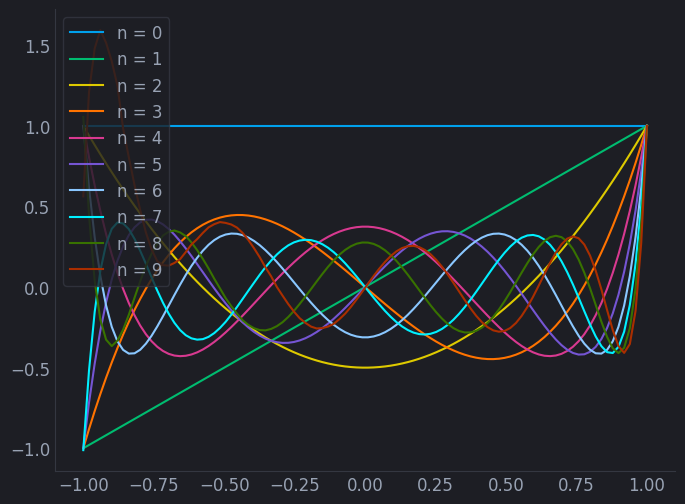

In [6]:
from jaxtyping import Array, Float
from jax.scipy import special

@eqx.filter_jit
def choose(x, y):
    return jnp.exp(special.gammaln(x + 1) - special.gammaln(y + 1) - special.gammaln(x - y + 1))

@eqx.filter_jit
def legendre_poly_coef(n, k):
    return choose(n, k) * choose(n + k, k)

@eqx.filter_vmap
@eqx.filter_jit
def legendre_poly(x: Float[Array, ''], n: int):
    kk = jnp.arange(n + 1)
    return jnp.dot(((x - 1) / 2) ** kk, legendre_poly_coef(n, kk))


xx = jnp.linspace(-1, 1, 100)
for n in range(10):
    plt.plot(xx, legendre_poly(xx, n), label=f'n = {n}')

plt.legend()

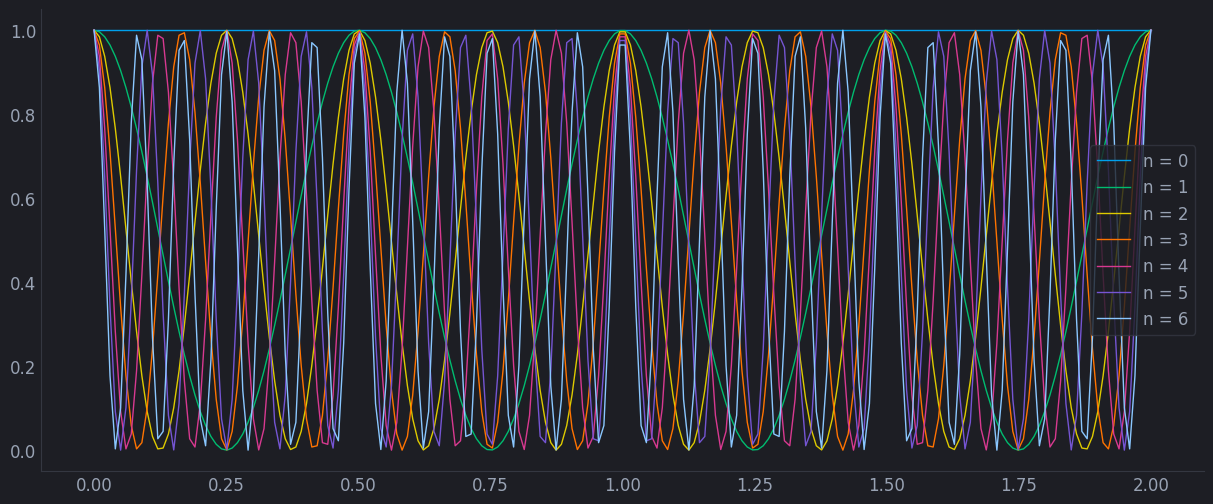

In [15]:
xx = jnp.linspace(0, 2, 200)
plt.subplots(figsize=(15, 6))
for n in range(0, 7, 1):
    plt.plot(xx, jnp.cos(n * (xx * 2 - 1) * jnp.pi) ** 2, label=f'n = {n}', lw=1)

plt.legend()

In [8]:
ncheby = 9
nnn = jnp.mgrid[:ncheby, :ncheby, :ncheby][:, ::1, ::1, ::1]
nnn = jnp.array(rearrange(nnn, 'd n1 n2 n3 -> n1 n2 n3 d'))
nnn = nnn[:, :, :, None, :]

basis = jnp.cos(nnn * (xyz * 2 - 1) * jnp.pi)
basis.shape

(9, 9, 9, 13824, 3)

In [21]:
cheby = basis.prod(axis=-1)
cheby = cheby

In [22]:
coefs = jnp.dot(cheby, dens) / jnp.sum(cheby ** 2, axis=-1)
coefs.shape

(9, 9, 9)

In [23]:
from einops import einsum
yhat = einsum(coefs, cheby, 'n1 n2 n3, n1 n2 n3 npt -> npt')
plot(yhat)

In [12]:
plot(2 * dens - 1)

In [13]:
jnp.mean(jnp.abs(yhat - dens))

Array(0.9529514, dtype=float32)

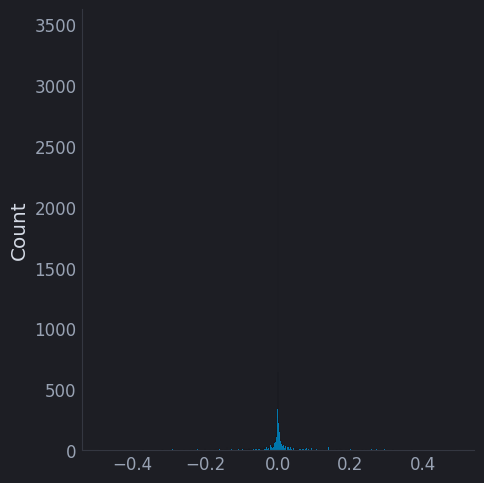

In [25]:
sns.displot(yhat - dens)